In [ ]:
#!pip install tensorflow numpy matplotlib seaborn scikit-learn opencv-python

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import ResNet50, VGG16, EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import cv2
import time
import os


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-9a2ec2a6e974>", line 3, in <cell line: 0>
    import tensorflow as tf
  File "/usr/local/lib/python3.11/dist-packages/tensorflow/__init__.py", line 49, in <module>
    from tensorflow._api.v2 import __internal__
  File "/usr/local/lib/python3.11/dist-packages/tensorflow/_api/v2/__internal__/__init__.py", line 11, in <module>
    from tensorflow._api.v2.__internal__ import distribute
  File "/usr/local/lib/python3.11/dist-packages/tensorflow/_api/v2/__internal__/distribute/__init__.py", line 8, in <module>
    from tensorflow._api.v2.__internal__.distribute import combinations
  File "/usr/local/lib/python3.11/dist-packages/tensorflow/_api/v2/__internal__/distribute/combinations/__init__.py", line 8, in <module>
    from tensorflow.python.distribute.combinations import e

In [ ]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


In [ ]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

#DATA PREPROCESSING

In [ ]:
def load_and_preprocess_data():
    """
    Load CIFAR-10 dataset and preprocess it:
    - Normalize pixel values to [0,1]
    - Split into train and test sets

    Returns:
        Tuple of (x_train, y_train, x_test, y_test, class_names)
    """
    # Load CIFAR-10 dataset
    # CIFAR-10 contains 50,000 training images and 10,000 test images
    # Each image is 32x32 pixels with 3 color channels (RGB)
    print("Loading CIFAR-10 dataset...")
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()

    # Define class names for CIFAR-10
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

    # Normalize pixel values to range [0, 1]
    # This helps with gradient stability during training
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0

    # Convert class labels to one-hot encoding for categorical cross-entropy loss
    y_train = tf.keras.utils.to_categorical(y_train, len(class_names))
    y_test = tf.keras.utils.to_categorical(y_test, len(class_names))

    print(f"Training samples: {x_train.shape[0]}")
    print(f"Test samples: {x_test.shape[0]}")
    print(f"Image dimensions: {x_train.shape[1:]}")
    print(f"Number of classes: {len(class_names)}")

    return x_train, y_train, x_test, y_test, class_names

In [ ]:
def create_data_generators(x_train, y_train, x_test, y_test, input_shape=(224, 224)):
    """
    Create data generators with augmentation for training.

    Args:
        x_train: Training images
        y_train: Training labels
        x_test: Test images
        y_test: Test labels
        input_shape: Required input shape for the model (height, width)

    Returns:
        train_generator, validation_generator, test_generator
    """
    # First, resize all images to the target input shape if they're not already that size
    if x_train.shape[1:3] != input_shape:
        x_train_resized = np.zeros((x_train.shape[0], input_shape[0], input_shape[1], x_train.shape[3]), dtype=np.float32)
        for i in range(len(x_train)):
            x_train_resized[i] = tf.image.resize(x_train[i], input_shape).numpy()

        x_test_resized = np.zeros((x_test.shape[0], input_shape[0], input_shape[1], x_test.shape[3]), dtype=np.float32)
        for i in range(len(x_test)):
            x_test_resized[i] = tf.image.resize(x_test[i], input_shape).numpy()
    else:
        x_train_resized = x_train
        x_test_resized = x_test

    # Create data generators with augmentation
    train_datagen = ImageDataGenerator(
        rotation_range=15,           # Random rotations up to 15 degrees
        width_shift_range=0.1,       # Random horizontal shifts up to 10%
        height_shift_range=0.1,      # Random vertical shifts up to 10%
        horizontal_flip=True,        # Randomly flip images horizontally
        zoom_range=0.1,              # Random zoom in/out up to 10%
        validation_split=0.2         # Use 20% of training data for validation
    )

    # Validation data should not be augmented
    validation_datagen = ImageDataGenerator(
        validation_split=0.2
    )

    # Test data generator (no augmentation)
    test_datagen = ImageDataGenerator()

    # Create generators with the resized images
    train_generator = train_datagen.flow(
        x_train_resized, y_train,
        batch_size=32,
        subset='training'
    )

    validation_generator = validation_datagen.flow(
        x_train_resized, y_train,
        batch_size=32,
        subset='validation'
    )

    test_generator = test_datagen.flow(
        x_test_resized, y_test,
        batch_size=32,
        shuffle=False
    )

    return train_generator, validation_generator, test_generator

In [ ]:
def visualize_augmentations(train_generator):
    """
    Visualize examples of augmented images from the data generator.

    Args:
        train_generator: Training data generator with augmentations
    """
    # Get a batch of augmented images
    images, labels = next(train_generator)

    # Display a grid of augmented images
    plt.figure(figsize=(12, 8))
    for i in range(min(9, len(images))):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title(f"Class: {np.argmax(labels[i])}")
        plt.axis('off')
    plt.tight_layout()
    plt.suptitle("Examples of Augmented Training Images")
    plt.show()

# MODEL DEVELOPMENT

In [ ]:
def create_baseline_model(input_shape, num_classes):
    """
    Create a baseline CNN model from scratch.

    Args:
        input_shape: Input image dimensions (height, width, channels)
        num_classes: Number of output classes

    Returns:
        Compiled model
    """
    # Define a simple CNN architecture for the baseline model
    model = Sequential([
        # First convolutional block
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.25),  # Dropout to reduce overfitting

        # Second convolutional block
        tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.25),

        # Third convolutional block
        tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.25),

        # Flatten and fully connected layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')  # Output layer with softmax
    ])

    # Compile the model with Adam optimizer
    model.compile(
        optimizer=Adam(learning_rate=0.001),  # Adam optimizer with initial learning rate
        loss='categorical_crossentropy',      # Appropriate loss for multi-class classification
        metrics=['accuracy']                  # Track accuracy during training
    )

    print("Baseline CNN model summary:")
    model.summary()

    return model

In [ ]:
def create_transfer_learning_model(base_model_name, input_shape, num_classes):
    """
    Create a transfer learning model using a pre-trained base model.

    Args:
        base_model_name: Name of the pre-trained model to use
        input_shape: Input dimensions for the model
        num_classes: Number of output classes

    Returns:
        Compiled model
    """
    # Load the appropriate pre-trained model with weights from ImageNet
    # and without the top classification layers
    if base_model_name == 'ResNet50':
        # ResNet (Residual Networks) introduced residual connections to enable training of very deep networks
        # Paper: "Deep Residual Learning for Image Recognition" by He et al. (2016)
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
        model_name = 'ResNet50'

    elif base_model_name == 'VGG16':
        # VGG uses a simple architecture with many small convolutional filters
        # Paper: "Very Deep Convolutional Networks for Large-Scale Image Recognition" by Simonyan & Zisserman (2015)
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
        model_name = 'VGG16'

    elif base_model_name == 'EfficientNetB0':
        # EfficientNet uses compound scaling to efficiently balance depth, width, and resolution
        # Paper: "EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks" by Tan & Le (2019)
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
        model_name = 'EfficientNetB0'

    else:
        raise ValueError(f"Unsupported model: {base_model_name}")

    # Freeze the base model layers to preserve learned weights
    # This prevents the pre-trained weights from being modified during initial training
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom classification layers on top of the base model
    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Global average pooling reduces parameters
    x = Dense(1024, activation='relu')(x)  # Additional dense layer
    x = Dropout(0.5)(x)  # Dropout to prevent overfitting
    predictions = Dense(num_classes, activation='softmax')(x)  # Output layer

    # Create the model with the base and custom layers
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.0001),  # Lower learning rate for transfer learning
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    print(f"{model_name} transfer learning model summary:")
    model.summary()

    return model, model_name


In [ ]:
def setup_callbacks(model_name):
    """
    Set up training callbacks for early stopping, learning rate reduction, and model checkpointing.

    Args:
        model_name: Name of the model for saving checkpoints

    Returns:
        List of callbacks
    """
    # Create directory for saving model checkpoints if it doesn't exist
    if not os.path.exists('model_checkpoints'):
        os.makedirs('model_checkpoints')

    # Early stopping to prevent overfitting
    # Stops training when validation loss doesn't improve after patience epochs
    early_stopping = EarlyStopping(
        monitor='val_loss',         # Monitor validation loss
        patience=10,                # Wait for 10 epochs before stopping
        restore_best_weights=True,  # Restore model to best weights
        verbose=1
    )

    # Reduce learning rate when learning plateaus
    # This helps fine-tune the model when progress slows
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',         # Monitor validation loss
        factor=0.2,                 # Reduce learning rate by 80%
        patience=5,                 # Wait for 5 epochs before reducing
        min_lr=1e-6,                # Minimum learning rate
        verbose=1
    )

    # Save the best model during training
    checkpoint = ModelCheckpoint(
        filepath=f'model_checkpoints/{model_name}_best.h5',
        monitor='val_accuracy',     # Monitor validation accuracy
        save_best_only=True,        # Only save when model improves
        mode='max',                 # Higher accuracy is better
        verbose=1
    )

    return [early_stopping, reduce_lr, checkpoint]



In [ ]:
def train_model(model, model_name, train_generator, validation_generator, epochs=50):
    """
    Train the model using the data generators.

    Args:
        model: Compiled model to train
        model_name: Name of the model for callbacks
        train_generator: Training data generator
        validation_generator: Validation data generator
        epochs: Maximum number of training epochs

    Returns:
        Training history and trained model
    """
    # Set up callbacks for training
    callbacks = setup_callbacks(model_name)

    print(f"Training {model_name} model...")
    start_time = time.time()

    # Train the model
    # steps_per_epoch and validation_steps define how many batches to use in each epoch
    history = model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=len(validation_generator),
        callbacks=callbacks,
        verbose=1
    )

    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")

    return history, model

In [ ]:
def evaluate_model(model, test_generator, class_names):
    """
    Evaluate the model on the test dataset.

    Args:
        model: Trained model to evaluate
        test_generator: Test data generator
        class_names: List of class names

    Returns:
        Evaluation metrics
    """
    print("Evaluating model...")

    # Measure inference time
    start_time = time.time()

    # Get predictions for all test images
    # We need to reset the generator to ensure we process all test images
    test_generator.reset()
    y_pred_probs = model.predict(test_generator, steps=len(test_generator))
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Get true labels
    y_true = np.argmax(test_generator.y, axis=1)

    inference_time = time.time() - start_time
    print(f"Inference time for {len(y_true)} images: {inference_time:.2f} seconds")
    print(f"Average inference time per image: {(inference_time/len(y_true))*1000:.2f} ms")

    # Calculate standard evaluation metrics
    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
    print(f"Test accuracy: {test_accuracy:.4f}")
    print(f"Test loss: {test_loss:.4f}")

    # Generate and display classification report with precision, recall, and F1-score
    print("\nClassification Report:")
    report = classification_report(y_true, y_pred, target_names=class_names)
    print(report)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    # Visualize some predictions
    visualize_predictions(test_generator.x[:20], y_pred[:20], y_true[:20], class_names)

    # Return evaluation metrics for comparison
    return {
        'accuracy': test_accuracy,
        'loss': test_loss,
        'inference_time': inference_time,
        'average_inference_time': inference_time/len(y_true)
    }


In [ ]:
def visualize_predictions(images, y_pred, y_true, class_names):
    """
    Visualize model predictions on sample images.

    Args:
        images: Sample images
        y_pred: Predicted labels
        y_true: True labels
        class_names: List of class names
    """
    plt.figure(figsize=(12, 10))
    for i in range(min(16, len(images))):
        plt.subplot(4, 4, i+1)
        plt.imshow(images[i])
        color = 'green' if y_pred[i] == y_true[i] else 'red'
        title = f"True: {class_names[y_true[i]]}\nPred: {class_names[y_pred[i]]}"
        plt.title(title, color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.suptitle("Model Predictions on Test Images")
    plt.subplots_adjust(top=0.9)
    plt.show()


#MAIN EXECUTION

In [ ]:
def main():
    """
    Main function to execute the complete pipeline.
    """
    print("="*50)
    print("IMAGE CLASSIFICATION WITH TRANSFER LEARNING")
    print("="*50)

    # 1. Data Preprocessing
    x_train, y_train, x_test, y_test, class_names = load_and_preprocess_data()

    # 2. Model Development and Training
    # Dictionary to store results for comparison
    model_results = {}

    # 2.1 Baseline CNN Model (32x32 images)
    print("\n" + "="*30 + " BASELINE CNN MODEL " + "="*30)

    # Create baseline CNN with input shape matching CIFAR-10 images
    baseline_input_shape = (32, 32, 3)
    baseline_model = create_baseline_model(baseline_input_shape, len(class_names))

    # Create data generators for baseline model (32x32 images)
    baseline_train_gen, baseline_val_gen, baseline_test_gen = create_data_generators(
        x_train, y_train, x_test, y_test, input_shape=(32, 32)
    )

    # Visualize some augmented training images from baseline generators
    print("Visualizing baseline model training images (32x32):")
    visualize_augmentations(baseline_train_gen)

    # Train the baseline model
    baseline_history, baseline_model = train_model(
        baseline_model, "Baseline_CNN", baseline_train_gen, baseline_val_gen, epochs=40
    )

    # Evaluate the baseline model
    baseline_metrics = evaluate_model(baseline_model, baseline_test_gen, class_names)
    model_results['Baseline CNN'] = baseline_metrics

    # 2.2 Transfer Learning Models (224x224 images)
    # Create data generators for transfer learning models
    transfer_input_shape = (224, 224, 3)
    transfer_train_gen, transfer_val_gen, transfer_test_gen = create_data_generators(
        x_train, y_train, x_test, y_test, input_shape=(224, 224)
    )

    # Visualize some augmented training images from transfer learning generators
    print("Visualizing transfer learning model training images (224x224):")
    visualize_augmentations(transfer_train_gen)

    # ResNet50
    print("\n" + "="*30 + " RESNET50 MODEL " + "="*30)
    resnet_model, resnet_name = create_transfer_learning_model('ResNet50', transfer_input_shape, len(class_names))
    resnet_history, resnet_model = train_model(
        resnet_model, resnet_name, transfer_train_gen, transfer_val_gen, epochs=1
    )
    resnet_metrics = evaluate_model(resnet_model, transfer_test_gen, class_names)
    model_results['ResNet50'] = resnet_metrics

    # VGG16
    print("\n" + "="*30 + " VGG16 MODEL " + "="*30)
    vgg_model, vgg_name = create_transfer_learning_model('VGG16', transfer_input_shape, len(class_names))
    vgg_history, vgg_model = train_model(
        vgg_model, vgg_name, transfer_train_gen, transfer_val_gen, epochs=1
    )
    vgg_metrics = evaluate_model(vgg_model, transfer_test_gen, class_names)
    model_results['VGG16'] = vgg_metrics

    # EfficientNetB0
    print("\n" + "="*30 + " EFFICIENTNET MODEL " + "="*30)
    efficientnet_model, efficientnet_name = create_transfer_learning_model('EfficientNetB0', transfer_input_shape, len(class_names))
    efficientnet_history, efficientnet_model = train_model(
        efficientnet_model, efficientnet_name, transfer_train_gen, transfer_val_gen, epochs=1
    )
    efficientnet_metrics = evaluate_model(efficientnet_model, transfer_test_gen, class_names)
    model_results['EfficientNetB0'] = efficientnet_metrics

    # 3. Model Comparison
    print("\n" + "="*30 + " MODEL COMPARISON " + "="*30)
    compare_models(model_results)

    print("\n" + "="*50)
    print("COMPLETE PIPELINE EXECUTION FINISHED")
    print("="*50)

IMAGE CLASSIFICATION WITH TRANSFER LEARNING
Loading CIFAR-10 dataset...
Training samples: 50000
Test samples: 10000
Image dimensions: (32, 32, 3)
Number of classes: 10

============================== BASELINE CNN MODEL ==============================
Baseline CNN model summary:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,345,066 (5.13 MB)

 Trainable params: 1,343,146 (5.12 MB)

 Non-trainable params: 1,920 (7.50 KB)

Visualizing baseline model training images (32x32):


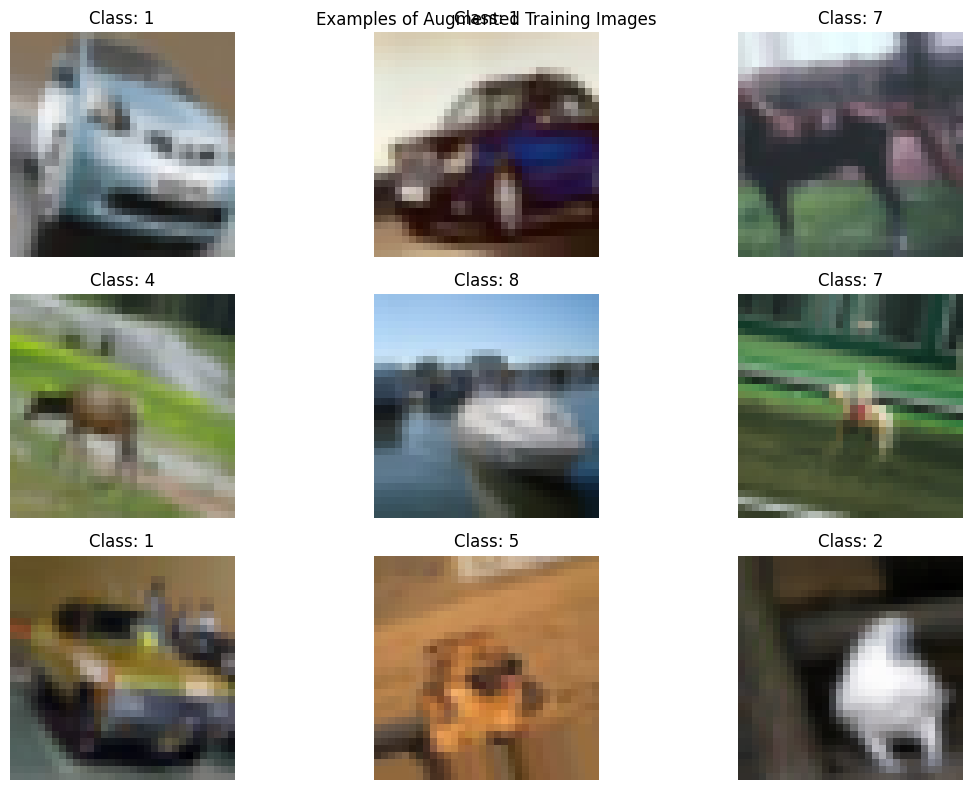

Training Baseline_CNN model...
Epoch 1/2


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.3263 - loss: 2.1419
Epoch 1: val_accuracy improved from -inf to 0.49430, saving model to model_checkpoints/Baseline_CNN_best.h5


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 404s 318ms/step - accuracy: 0.3263 - loss: 2.1416 - val_accuracy: 0.4943 - val_loss: 1.5297 - learning_rate: 0.0010
Epoch 2/2
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.5240 - loss: 1.3326
Epoch 2: val_accuracy improved from 0.49430 to 0.61080, saving model to model_checkpoints/Baseline_CNN_best.h5


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 440s 316ms/step - accuracy: 0.5240 - loss: 1.3326 - val_accuracy: 0.6108 - val_loss: 1.1162 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 2.
Training completed in 844.35 seconds
Evaluating model...
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 73ms/step
Inference time for 10000 images: 23.40 seconds
Average inference time per image: 2.34 ms
313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 71ms/step - accuracy: 0.6085 - loss: 1.0987
Test accuracy: 0.6124
Test loss: 1.1043

Classification Report:
              precision    recall  f1-score   support

    airplane       0.77      0.51      0.61      1000
  automobile       0.67      0.77      0.72      1000
        bird       0.69      0.39      0.50      1000
         cat       0.43      0.37      0.40      1000
        deer       0.70      0.39      0.50      1000
         dog       0.47      0.70      0.56      1000
        frog       0.69      0.75      0.72      1000
       horse       0.68      0.

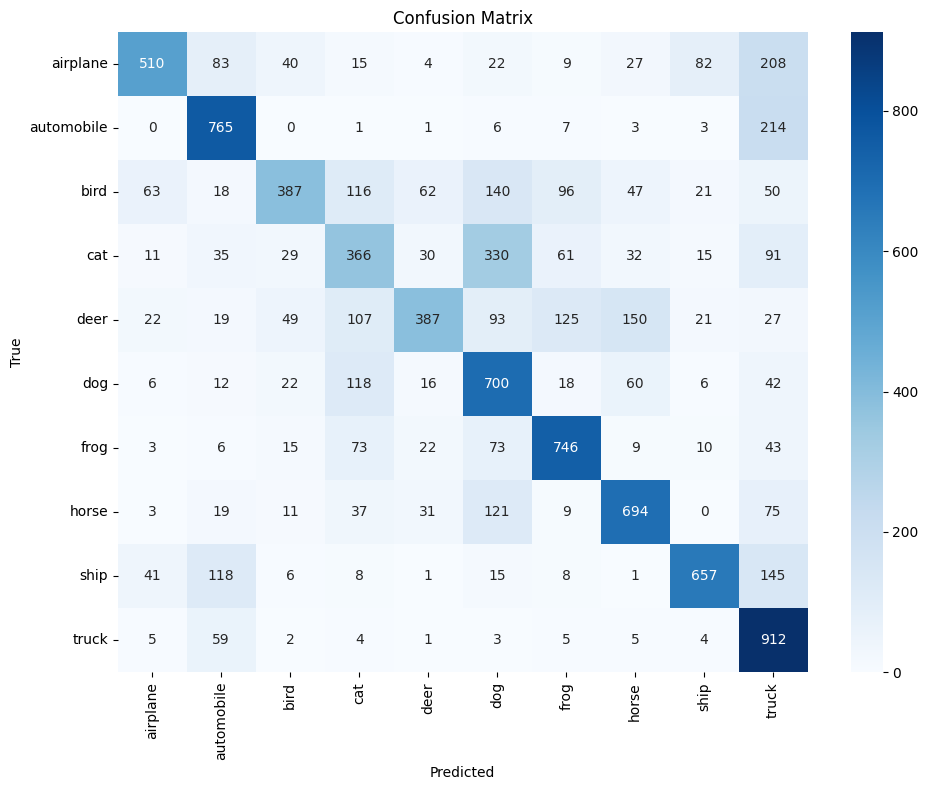

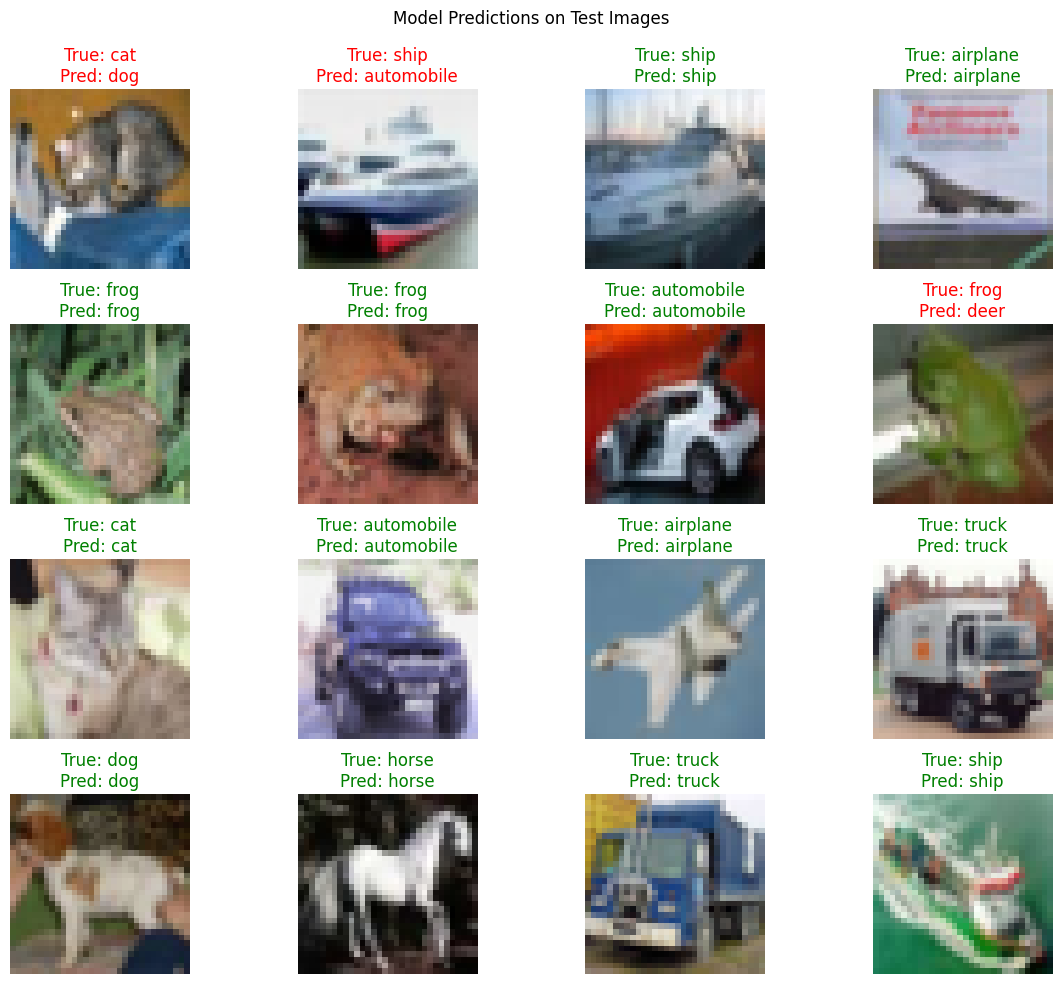

In [ ]:
# Run the main function
if __name__ == '__main__':
    try:
        main()
    except Exception as e:
        print(f"An error occurred in the main pipeline: {e}")
        import traceback
        traceback.print_exc()

In [ ]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 85.6 MB/s eta 0:00:00


Using device: cuda
1. Preparing data...
2. Creating model...
Model parameters: 4028170
3. Setting up training...
Starting training...

Epoch 1/40


Validation: 100%|██████████| 40/40 [00:04<00:00,  8.53it/s, loss=1.68, acc=36.8]


Time: 50.74s | Train Loss: 1.8430, Train Acc: 30.54% | Val Loss: 1.6764, Val Acc: 36.76%
Validation accuracy improved from 0.00% to 36.76% - saving checkpoint

Epoch 2/40


Validation: 100%|██████████| 40/40 [00:02<00:00, 19.37it/s, loss=1.46, acc=48.4]


Time: 45.26s | Train Loss: 1.5635, Train Acc: 42.58% | Val Loss: 1.4242, Val Acc: 48.42%
Validation accuracy improved from 36.76% to 48.42% - saving checkpoint

Epoch 3/40


Validation: 100%|██████████| 40/40 [00:03<00:00, 13.06it/s, loss=1.35, acc=51.1]


Time: 43.37s | Train Loss: 1.3950, Train Acc: 48.95% | Val Loss: 1.3540, Val Acc: 51.14%
Validation accuracy improved from 48.42% to 51.14% - saving checkpoint

Epoch 4/40


Validation: 100%|██████████| 40/40 [00:02<00:00, 19.08it/s, loss=1.28, acc=53.9]


Time: 42.10s | Train Loss: 1.3001, Train Acc: 52.63% | Val Loss: 1.2528, Val Acc: 53.88%
Validation accuracy improved from 51.14% to 53.88% - saving checkpoint

Epoch 5/40


Validation: 100%|██████████| 40/40 [00:02<00:00, 19.14it/s, loss=1.2, acc=57]


Time: 41.80s | Train Loss: 1.2334, Train Acc: 55.51% | Val Loss: 1.1661, Val Acc: 57.00%
Validation accuracy improved from 53.88% to 57.00% - saving checkpoint

Epoch 6/40


Validation: 100%|██████████| 40/40 [00:03<00:00, 13.18it/s, loss=1.18, acc=58.4]


Time: 43.73s | Train Loss: 1.1654, Train Acc: 57.98% | Val Loss: 1.1491, Val Acc: 58.42%
Validation accuracy improved from 57.00% to 58.42% - saving checkpoint

Epoch 7/40


Validation: 100%|██████████| 40/40 [00:02<00:00, 18.86it/s, loss=1.09, acc=61]


Time: 42.37s | Train Loss: 1.1148, Train Acc: 60.10% | Val Loss: 1.0917, Val Acc: 60.98%
Validation accuracy improved from 58.42% to 60.98% - saving checkpoint

Epoch 8/40


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.88it/s, loss=1.05, acc=61.9]


Time: 42.82s | Train Loss: 1.0726, Train Acc: 61.65% | Val Loss: 1.0534, Val Acc: 61.86%
Validation accuracy improved from 60.98% to 61.86% - saving checkpoint

Epoch 9/40


Validation: 100%|██████████| 40/40 [00:02<00:00, 13.62it/s, loss=1.07, acc=60.9]


Time: 42.97s | Train Loss: 1.0229, Train Acc: 63.15% | Val Loss: 1.0433, Val Acc: 60.92%

Epoch 10/40


Validation: 100%|██████████| 40/40 [00:02<00:00, 19.14it/s, loss=1.03, acc=64.3]


Time: 42.02s | Train Loss: 0.9898, Train Acc: 64.52% | Val Loss: 0.9769, Val Acc: 64.34%
Validation accuracy improved from 61.86% to 64.34% - saving checkpoint

Epoch 11/40


Validation: 100%|██████████| 40/40 [00:02<00:00, 18.44it/s, loss=0.959, acc=66.2]


Time: 42.15s | Train Loss: 0.9443, Train Acc: 66.32% | Val Loss: 0.9111, Val Acc: 66.24%
Validation accuracy improved from 64.34% to 66.24% - saving checkpoint

Epoch 12/40


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.81it/s, loss=0.905, acc=66.7]


Time: 42.66s | Train Loss: 0.9106, Train Acc: 67.60% | Val Loss: 0.9053, Val Acc: 66.74%
Validation accuracy improved from 66.24% to 66.74% - saving checkpoint

Epoch 13/40


Validation: 100%|██████████| 40/40 [00:02<00:00, 18.80it/s, loss=0.875, acc=68.6]


Time: 42.45s | Train Loss: 0.8780, Train Acc: 68.78% | Val Loss: 0.8753, Val Acc: 68.60%
Validation accuracy improved from 66.74% to 68.60% - saving checkpoint

Epoch 14/40


Validation: 100%|██████████| 40/40 [00:02<00:00, 18.81it/s, loss=0.894, acc=69.5]


Time: 42.06s | Train Loss: 0.8474, Train Acc: 69.90% | Val Loss: 0.8717, Val Acc: 69.50%
Validation accuracy improved from 68.60% to 69.50% - saving checkpoint

Epoch 15/40


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.52it/s, loss=0.88, acc=68.4]


Time: 42.65s | Train Loss: 0.8252, Train Acc: 70.34% | Val Loss: 0.8802, Val Acc: 68.42%

Epoch 16/40


Validation: 100%|██████████| 40/40 [00:02<00:00, 18.54it/s, loss=0.828, acc=71.8]


Time: 42.31s | Train Loss: 0.7938, Train Acc: 71.75% | Val Loss: 0.7863, Val Acc: 71.84%
Validation accuracy improved from 69.50% to 71.84% - saving checkpoint

Epoch 17/40


Validation: 100%|██████████| 40/40 [00:02<00:00, 18.97it/s, loss=0.842, acc=71.6]


Time: 42.10s | Train Loss: 0.7702, Train Acc: 72.72% | Val Loss: 0.7995, Val Acc: 71.58%

Epoch 18/40


Validation: 100%|██████████| 40/40 [00:02<00:00, 19.16it/s, loss=0.809, acc=73.1]


Time: 42.06s | Train Loss: 0.7386, Train Acc: 73.83% | Val Loss: 0.7683, Val Acc: 73.14%
Validation accuracy improved from 71.84% to 73.14% - saving checkpoint

Epoch 19/40


Validation: 100%|██████████| 40/40 [00:02<00:00, 17.73it/s, loss=0.764, acc=73.1]


Time: 42.47s | Train Loss: 0.7219, Train Acc: 74.65% | Val Loss: 0.7642, Val Acc: 73.14%

Epoch 20/40


Validation: 100%|██████████| 40/40 [00:02<00:00, 18.89it/s, loss=0.808, acc=73]


Time: 42.11s | Train Loss: 0.7049, Train Acc: 75.06% | Val Loss: 0.7672, Val Acc: 72.96%

Epoch 21/40


Validation: 100%|██████████| 40/40 [00:02<00:00, 18.93it/s, loss=0.783, acc=74]


Time: 42.24s | Train Loss: 0.6850, Train Acc: 75.97% | Val Loss: 0.7438, Val Acc: 73.96%
Validation accuracy improved from 73.14% to 73.96% - saving checkpoint

Epoch 22/40


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.29it/s, loss=0.771, acc=74.5]


Time: 42.76s | Train Loss: 0.6597, Train Acc: 76.61% | Val Loss: 0.7519, Val Acc: 74.48%
Validation accuracy improved from 73.96% to 74.48% - saving checkpoint

Epoch 23/40


Validation: 100%|██████████| 40/40 [00:02<00:00, 18.50it/s, loss=0.715, acc=75]


Time: 42.09s | Train Loss: 0.6358, Train Acc: 77.18% | Val Loss: 0.6972, Val Acc: 75.00%
Validation accuracy improved from 74.48% to 75.00% - saving checkpoint

Epoch 24/40


Validation: 100%|██████████| 40/40 [00:02<00:00, 17.15it/s, loss=0.722, acc=75.5]


Time: 42.36s | Train Loss: 0.6239, Train Acc: 77.92% | Val Loss: 0.7035, Val Acc: 75.54%
Validation accuracy improved from 75.00% to 75.54% - saving checkpoint

Epoch 25/40


Validation: 100%|██████████| 40/40 [00:03<00:00, 13.21it/s, loss=0.718, acc=74.5]


Time: 43.11s | Train Loss: 0.6017, Train Acc: 78.61% | Val Loss: 0.6999, Val Acc: 74.46%

Epoch 26/40


Validation: 100%|██████████| 40/40 [00:02<00:00, 18.71it/s, loss=0.724, acc=76.7]


Time: 42.42s | Train Loss: 0.5838, Train Acc: 79.20% | Val Loss: 0.6877, Val Acc: 76.74%
Validation accuracy improved from 75.54% to 76.74% - saving checkpoint

Epoch 27/40


Validation: 100%|██████████| 40/40 [00:02<00:00, 18.48it/s, loss=0.691, acc=75.9]


Time: 42.45s | Train Loss: 0.5713, Train Acc: 79.69% | Val Loss: 0.6910, Val Acc: 75.94%

Epoch 28/40


Validation: 100%|██████████| 40/40 [00:03<00:00, 13.22it/s, loss=0.685, acc=76.7]


Time: 43.10s | Train Loss: 0.5526, Train Acc: 80.30% | Val Loss: 0.6675, Val Acc: 76.72%

Epoch 29/40


Validation: 100%|██████████| 40/40 [00:02<00:00, 18.32it/s, loss=0.698, acc=76.9]


Time: 42.49s | Train Loss: 0.5390, Train Acc: 80.74% | Val Loss: 0.6808, Val Acc: 76.92%
Validation accuracy improved from 76.74% to 76.92% - saving checkpoint

Epoch 30/40


Validation: 100%|██████████| 40/40 [00:02<00:00, 18.27it/s, loss=0.682, acc=77.1]


Time: 42.38s | Train Loss: 0.5179, Train Acc: 81.64% | Val Loss: 0.6652, Val Acc: 77.10%
Validation accuracy improved from 76.92% to 77.10% - saving checkpoint

Epoch 31/40


Validation: 100%|██████████| 40/40 [00:02<00:00, 14.35it/s, loss=0.654, acc=78.1]


Time: 42.93s | Train Loss: 0.5043, Train Acc: 82.15% | Val Loss: 0.6544, Val Acc: 78.06%
Validation accuracy improved from 77.10% to 78.06% - saving checkpoint

Epoch 32/40


Validation: 100%|██████████| 40/40 [00:02<00:00, 18.41it/s, loss=0.692, acc=77.2]


Time: 42.38s | Train Loss: 0.4968, Train Acc: 82.49% | Val Loss: 0.6746, Val Acc: 77.20%

Epoch 33/40


Validation: 100%|██████████| 40/40 [00:02<00:00, 18.93it/s, loss=0.647, acc=78.4]


Time: 42.21s | Train Loss: 0.4866, Train Acc: 82.70% | Val Loss: 0.6472, Val Acc: 78.44%
Validation accuracy improved from 78.06% to 78.44% - saving checkpoint

Epoch 34/40


Validation: 100%|██████████| 40/40 [00:02<00:00, 15.14it/s, loss=0.678, acc=77.7]


Time: 42.64s | Train Loss: 0.4748, Train Acc: 83.08% | Val Loss: 0.6608, Val Acc: 77.74%

Epoch 35/40


Validation: 100%|██████████| 40/40 [00:02<00:00, 18.49it/s, loss=0.679, acc=78.1]


Time: 42.41s | Train Loss: 0.4654, Train Acc: 83.50% | Val Loss: 0.6450, Val Acc: 78.12%

Epoch 36/40


Validation: 100%|██████████| 40/40 [00:02<00:00, 18.24it/s, loss=0.64, acc=78.9]


Time: 42.33s | Train Loss: 0.4611, Train Acc: 83.66% | Val Loss: 0.6400, Val Acc: 78.86%
Validation accuracy improved from 78.44% to 78.86% - saving checkpoint

Epoch 37/40


Validation: 100%|██████████| 40/40 [00:02<00:00, 18.39it/s, loss=0.634, acc=78.2]


Time: 42.33s | Train Loss: 0.4542, Train Acc: 83.77% | Val Loss: 0.6339, Val Acc: 78.16%

Epoch 38/40


Validation: 100%|██████████| 40/40 [00:02<00:00, 16.13it/s, loss=0.664, acc=77.7]


Time: 42.83s | Train Loss: 0.4493, Train Acc: 84.23% | Val Loss: 0.6477, Val Acc: 77.74%

Epoch 39/40


Validation: 100%|██████████| 40/40 [00:02<00:00, 18.89it/s, loss=0.661, acc=78.2]


Time: 42.13s | Train Loss: 0.4489, Train Acc: 84.06% | Val Loss: 0.6446, Val Acc: 78.20%

Epoch 40/40


Validation: 100%|██████████| 40/40 [00:02<00:00, 18.84it/s, loss=0.678, acc=78.1]


Time: 42.23s | Train Loss: 0.4449, Train Acc: 84.28% | Val Loss: 0.6611, Val Acc: 78.10%


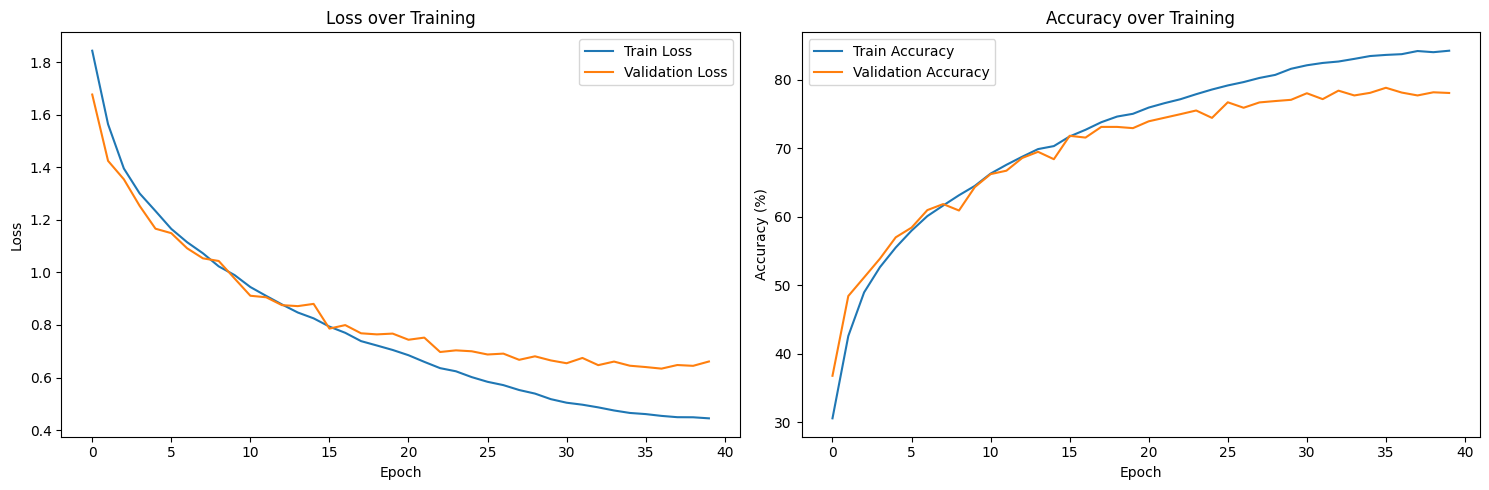

4. Evaluating model...


Testing: 100%|██████████| 79/79 [00:03<00:00, 19.80it/s]


Test Accuracy: 79.34%


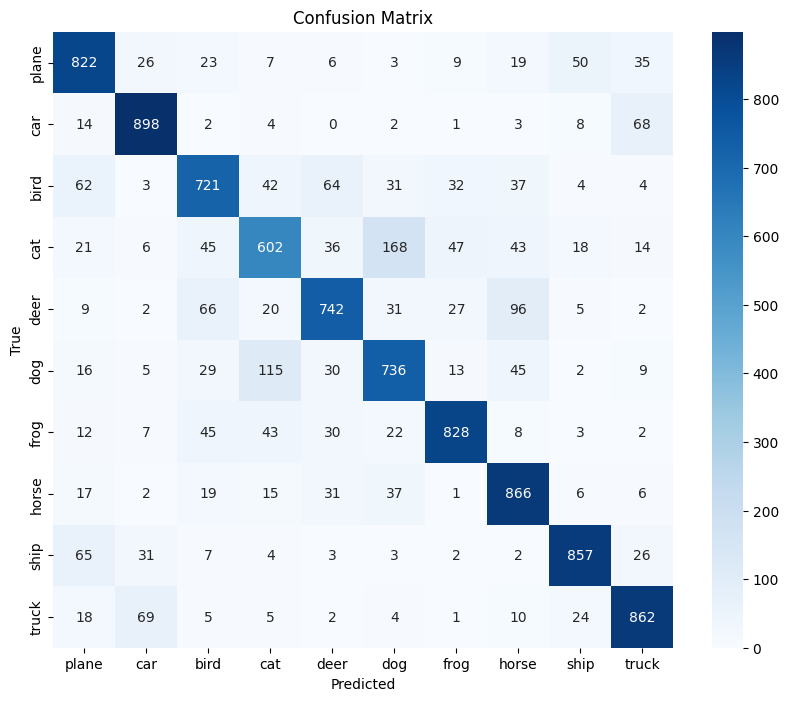

Classification Report:
              precision    recall  f1-score   support

       plane       0.78      0.82      0.80      1000
         car       0.86      0.90      0.88      1000
        bird       0.75      0.72      0.73      1000
         cat       0.70      0.60      0.65      1000
        deer       0.79      0.74      0.76      1000
         dog       0.71      0.74      0.72      1000
        frog       0.86      0.83      0.84      1000
       horse       0.77      0.87      0.81      1000
        ship       0.88      0.86      0.87      1000
       truck       0.84      0.86      0.85      1000

    accuracy                           0.79     10000
   macro avg       0.79      0.79      0.79     10000
weighted avg       0.79      0.79      0.79     10000



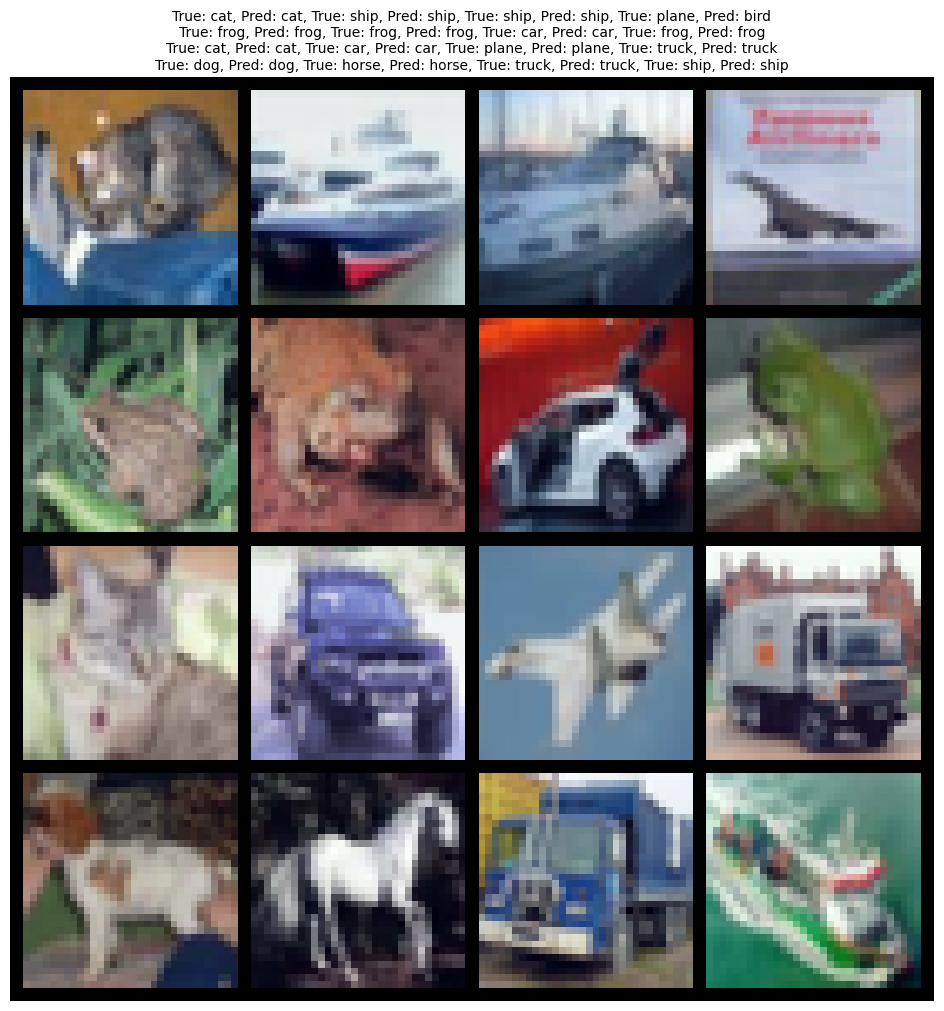

5. Deploying model...
Model saved to ./deployed_model/vit_cifar10.pth
Model exported to ONNX format at ./deployed_model/vit_cifar10.onnx
Complete! Model trained, evaluated, and deployed.


In [ ]:
"""
Vision Transformer (ViT) Implementation for CIFAR-10 Dataset
===============================================================
This script implements a complete data pipeline for training a Vision Transformer
on the CIFAR-10 dataset, following these stages:
1. Data preprocessing
2. Model definition
3. Training
4. Evaluation
5. Model deployment (saving and loading)
"""

import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm import tqdm
import time

# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ======================================================
# 1. Data Preprocessing
# ======================================================

class DataPreprocessor:
    def __init__(self, batch_size=64, img_size=32, val_split=0.1):
        self.batch_size = batch_size
        self.img_size = img_size
        self.val_split = val_split
        self.classes = ('plane', 'car', 'bird', 'cat', 'deer',
                        'dog', 'frog', 'horse', 'ship', 'truck')

    def get_transforms(self):
        # Define data transformations
        train_transform = transforms.Compose([
            transforms.RandomCrop(self.img_size, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465),
                                (0.2470, 0.2435, 0.2616))
        ])

        test_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465),
                                (0.2470, 0.2435, 0.2616))
        ])

        return train_transform, test_transform

    def load_data(self):
        # Get transforms
        train_transform, test_transform = self.get_transforms()

        # Download and load the training data
        trainset = datasets.CIFAR10(root='./data', train=True,
                                    download=True, transform=train_transform)

        # Create validation split
        val_size = int(len(trainset) * self.val_split)
        train_size = len(trainset) - val_size
        trainset, valset = random_split(trainset, [train_size, val_size])

        # Download and load the test data
        testset = datasets.CIFAR10(root='./data', train=False,
                                  download=True, transform=test_transform)

        # Create data loaders
        train_loader = DataLoader(trainset, batch_size=self.batch_size,
                                  shuffle=True, num_workers=2)
        val_loader = DataLoader(valset, batch_size=self.batch_size,
                                shuffle=False, num_workers=2)
        test_loader = DataLoader(testset, batch_size=self.batch_size,
                                shuffle=False, num_workers=2)

        return train_loader, val_loader, test_loader

    def visualize_batch(self, loader):
        # Get a batch of images
        dataiter = iter(loader)
        images, labels = next(dataiter)

        # Show images
        plt.figure(figsize=(10, 10))
        grid = make_grid(images[:16], nrow=4, normalize=True)
        plt.imshow(grid.permute(1, 2, 0).cpu())
        plt.axis('off')

        # Print labels
        label_names = [self.classes[labels[i]] for i in range(16)]
        plt.title('Sample Images: ' + ' '.join(label_names))
        plt.show()


# ======================================================
# 2. Model Definition: Vision Transformer (ViT)
# ======================================================

class PatchEmbedding(nn.Module):
    """Split image into patches and embed them."""

    def __init__(self, img_size, patch_size, in_channels=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2

        # Linear projection
        self.proj = nn.Conv2d(
            in_channels,
            embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

    def forward(self, x):
        """Run forward pass."""
        # (batch_size, channels, img_size, img_size) -> (batch_size, embed_dim, n_patches^0.5, n_patches^0.5)
        x = self.proj(x)
        # (batch_size, embed_dim, n_patches^0.5, n_patches^0.5) -> (batch_size, embed_dim, n_patches)
        x = x.flatten(2)
        # (batch_size, embed_dim, n_patches) -> (batch_size, n_patches, embed_dim)
        x = x.transpose(1, 2)

        return x


class Attention(nn.Module):
    """Attention mechanism."""

    def __init__(self, dim, n_heads=8, qkv_bias=True, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.n_heads = n_heads
        self.dim = dim
        self.head_dim = dim // n_heads
        self.scale = self.head_dim ** -0.5

        # QKV linear layers
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        """Run forward pass."""
        batch_size, n_tokens, dim = x.shape

        qkv = self.qkv(x)
        qkv = qkv.reshape(batch_size, n_tokens, 3, self.n_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        # Calculate attention scores
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        # Apply attention to values
        x = (attn @ v).transpose(1, 2).reshape(batch_size, n_tokens, dim)
        x = self.proj(x)
        x = self.proj_drop(x)

        return x


class MLP(nn.Module):
    """Multilayer perceptron."""

    def __init__(self, in_features, hidden_features, out_features, drop=0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        """Run forward pass."""
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)

        return x


class Block(nn.Module):
    """Transformer encoder block."""

    def __init__(self, dim, n_heads, mlp_ratio=4.0, qkv_bias=True,
                 drop=0., attn_drop=0., norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, n_heads=n_heads, qkv_bias=qkv_bias,
            attn_drop=attn_drop, proj_drop=drop
        )
        self.norm2 = norm_layer(dim)
        self.mlp = MLP(
            in_features=dim,
            hidden_features=int(dim * mlp_ratio),
            out_features=dim,
            drop=drop
        )

    def forward(self, x):
        """Run forward pass."""
        # Apply attention with residual connection
        x = x + self.attn(self.norm1(x))
        # Apply MLP with residual connection
        x = x + self.mlp(self.norm2(x))

        return x


class VisionTransformer(nn.Module):
    """Vision Transformer (ViT) model."""

    def __init__(
        self,
        img_size=32,
        patch_size=4,
        in_channels=3,
        n_classes=10,
        embed_dim=192,
        depth=12,
        n_heads=3,
        mlp_ratio=4.,
        qkv_bias=True,
        drop_rate=0.1,
        attn_drop_rate=0.
    ):
        super().__init__()

        # Patch embedding
        self.patch_embed = PatchEmbedding(
            img_size=img_size,
            patch_size=patch_size,
            in_channels=in_channels,
            embed_dim=embed_dim
        )
        n_patches = self.patch_embed.n_patches

        # Class token and position embedding
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, n_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)

        # Transformer blocks
        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim,
                n_heads=n_heads,
                mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias,
                drop=drop_rate,
                attn_drop=attn_drop_rate
            )
            for i in range(depth)
        ])

        # Normalization and classification head
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, n_classes)

        # Initialize weights
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward_features(self, x):
        # Extract patch embeddings
        x = self.patch_embed(x)
        batch_size = x.shape[0]

        # Add class token
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # Add position embeddings
        x = x + self.pos_embed
        x = self.pos_drop(x)

        # Apply Transformer blocks
        for block in self.blocks:
            x = block(x)

        # Apply normalization
        x = self.norm(x)

        # Return class token only
        return x[:, 0]

    def forward(self, x):
        # Extract features
        x = self.forward_features(x)
        # Classification head
        x = self.head(x)
        return x


# ======================================================
# 3. Training Pipeline
# ======================================================

class Trainer:
    def __init__(self, model, criterion, optimizer, scheduler=None,
                 device=torch.device("cpu"), checkpoint_dir="checkpoints"):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device
        self.checkpoint_dir = checkpoint_dir

        # Create checkpoint directory if it doesn't exist
        os.makedirs(checkpoint_dir, exist_ok=True)

        # Move model to device
        self.model.to(self.device)

        # Metrics history
        self.train_losses = []
        self.val_losses = []
        self.train_accs = []
        self.val_accs = []

    def train_epoch(self, train_loader):
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Progress bar
        pbar = tqdm(train_loader, desc="Training")

        for inputs, targets in pbar:
            # Move data to device
            inputs, targets = inputs.to(self.device), targets.to(self.device)

            # Zero the parameter gradients
            self.optimizer.zero_grad()

            # Forward pass
            outputs = self.model(inputs)
            loss = self.criterion(outputs, targets)

            # Backward pass and optimize
            loss.backward()
            self.optimizer.step()

            # Track statistics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            # Update progress bar
            pbar.set_postfix({
                'loss': running_loss / (pbar.n + 1),
                'acc': 100. * correct / total
            })

        # Calculate epoch metrics
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100. * correct / total

        # Store metrics
        self.train_losses.append(epoch_loss)
        self.train_accs.append(epoch_acc)

        return epoch_loss, epoch_acc

    def validate(self, val_loader):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            # Progress bar
            pbar = tqdm(val_loader, desc="Validation")

            for inputs, targets in pbar:
                # Move data to device
                inputs, targets = inputs.to(self.device), targets.to(self.device)

                # Forward pass
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)

                # Track statistics
                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

                # Update progress bar
                pbar.set_postfix({
                    'loss': running_loss / (pbar.n + 1),
                    'acc': 100. * correct / total
                })

        # Calculate epoch metrics
        epoch_loss = running_loss / len(val_loader)
        epoch_acc = 100. * correct / total

        # Store metrics
        self.val_losses.append(epoch_loss)
        self.val_accs.append(epoch_acc)

        return epoch_loss, epoch_acc

    def train(self, train_loader, val_loader, epochs=10):
        best_val_acc = 0.0

        for epoch in range(epochs):
            print(f"\nEpoch {epoch+1}/{epochs}")
            start_time = time.time()

            # Train one epoch
            train_loss, train_acc = self.train_epoch(train_loader)

            # Validate
            val_loss, val_acc = self.validate(val_loader)

            # Update learning rate
            if self.scheduler is not None:
                self.scheduler.step()

            # Print metrics
            epoch_time = time.time() - start_time
            print(f"Time: {epoch_time:.2f}s | "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

            # Save checkpoint if validation accuracy improved
            if val_acc > best_val_acc:
                print(f"Validation accuracy improved from {best_val_acc:.2f}% to {val_acc:.2f}% - saving checkpoint")
                best_val_acc = val_acc
                self.save_checkpoint(epoch, val_acc)

    def save_checkpoint(self, epoch, val_acc):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'val_acc': val_acc,
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'train_accs': self.train_accs,
            'val_accs': self.val_accs
        }

        if self.scheduler is not None:
            checkpoint['scheduler_state_dict'] = self.scheduler.state_dict()

        torch.save(checkpoint, f"{self.checkpoint_dir}/vit_cifar10_best.pth")

    def load_checkpoint(self, path):
        checkpoint = torch.load(path, map_location=self.device)

        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        if self.scheduler is not None and 'scheduler_state_dict' in checkpoint:
            self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

        self.train_losses = checkpoint['train_losses']
        self.val_losses = checkpoint['val_losses']
        self.train_accs = checkpoint['train_accs']
        self.val_accs = checkpoint['val_accs']

        epoch = checkpoint['epoch']
        val_acc = checkpoint['val_acc']

        print(f"Loaded checkpoint from epoch {epoch+1} with validation accuracy {val_acc:.2f}%")

        return epoch

    def plot_metrics(self):
        plt.figure(figsize=(15, 5))

        # Plot loss
        plt.subplot(1, 2, 1)
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Loss over Training')

        # Plot accuracy
        plt.subplot(1, 2, 2)
        plt.plot(self.train_accs, label='Train Accuracy')
        plt.plot(self.val_accs, label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()
        plt.title('Accuracy over Training')

        plt.tight_layout()
        plt.show()


# ======================================================
# 4. Evaluation
# ======================================================

class Evaluator:
    def __init__(self, model, device=torch.device("cpu"), classes=None):
        self.model = model
        self.device = device
        self.classes = classes if classes is not None else [str(i) for i in range(10)]

        # Move model to device
        self.model.to(self.device)
        self.model.eval()

    def evaluate(self, test_loader):
        correct = 0
        total = 0
        all_preds = []
        all_targets = []

        with torch.no_grad():
            for inputs, targets in tqdm(test_loader, desc="Testing"):
                # Move data to device
                inputs, targets = inputs.to(self.device), targets.to(self.device)

                # Forward pass
                outputs = self.model(inputs)
                _, predicted = outputs.max(1)

                # Track statistics
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

                # Save predictions and targets for confusion matrix
                all_preds.extend(predicted.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())

        # Calculate accuracy
        accuracy = 100. * correct / total
        print(f"Test Accuracy: {accuracy:.2f}%")

        return np.array(all_preds), np.array(all_targets), accuracy

    def confusion_matrix(self, preds, targets):
        from sklearn.metrics import confusion_matrix, classification_report
        import seaborn as sns

        # Compute confusion matrix
        cm = confusion_matrix(targets, preds)

        # Plot confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=self.classes, yticklabels=self.classes)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

        # Print classification report
        report = classification_report(targets, preds, target_names=self.classes)
        print("Classification Report:")
        print(report)

    def visualize_predictions(self, test_loader, num_images=16):
        # Get a batch of images
        dataiter = iter(test_loader)
        images, labels = next(dataiter)
        images, labels = images[:num_images], labels[:num_images]

        # Move to device and get predictions
        images, labels = images.to(self.device), labels.to(self.device)
        with torch.no_grad():
            outputs = self.model(images)
            _, preds = outputs.max(1)

        # Move back to CPU for visualization
        images = images.cpu()
        labels = labels.cpu()
        preds = preds.cpu()

        # Plot images with predictions
        plt.figure(figsize=(12, 12))
        grid = make_grid(images, nrow=4, normalize=True)
        plt.imshow(grid.permute(1, 2, 0))
        plt.axis('off')

        # Add title with actual and predicted labels
        label_names = [f"True: {self.classes[labels[i]]}, Pred: {self.classes[preds[i]]}" for i in range(num_images)]
        plt.title('\n'.join([', '.join(label_names[i:i+4]) for i in range(0, num_images, 4)]), fontsize=10)
        plt.show()


# ======================================================
# 5. Model Deployment
# ======================================================

class ModelDeployment:
    def __init__(self, model, classes=None, device=torch.device("cpu")):
        self.model = model
        self.device = device
        self.classes = classes if classes is not None else [str(i) for i in range(10)]

        # Move model to device
        self.model.to(self.device)
        self.model.eval()

    def save_model(self, path="./deployed_model/vit_cifar10.pth"):
        """Save model for deployment"""
        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(path), exist_ok=True)

        # Save model
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'classes': self.classes
        }, path)

        print(f"Model saved to {path}")

    def save_onnx(self, path="./deployed_model/vit_cifar10.onnx", img_size=32):
        """Export model to ONNX format for deployment"""
        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(path), exist_ok=True)

        # Create dummy input for ONNX export
        dummy_input = torch.randn(1, 3, img_size, img_size, device=self.device)

        # Export model to ONNX
        torch.onnx.export(
            self.model,
            dummy_input,
            path,
            export_params=True,
            opset_version=11,
            input_names=['input'],
            output_names=['output'],
            dynamic_axes={'input': {0: 'batch_size'},
                          'output': {0: 'batch_size'}}
        )

        print(f"Model exported to ONNX format at {path}")

    @staticmethod
    def load_model(path, model_class=VisionTransformer, device=torch.device("cpu")):
        """Load model for inference"""
        # Load checkpoint
        checkpoint = torch.load(path, map_location=device)

        # Initialize model (with default parameters, adjust as needed)
        model = model_class()
        model.load_state_dict(checkpoint['model_state_dict'])

        # Get classes
        classes = checkpoint.get('classes', [str(i) for i in range(10)])

        return ModelDeployment(model, classes, device)

    def predict(self, img):
        """Run inference on a single image"""
        # Prepare image for model
        if isinstance(img, np.ndarray):
            # Convert numpy array to tensor
            img = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0).float()
            # Apply normalization
            img = transforms.Normalize((0.4914, 0.4822, 0.4465),
                                     (0.2470, 0.2435, 0.2616))(img)

        # Move to device
        img = img.to(self.device)

        # Run inference
        with torch.no_grad():
            output = self.model(img)
            probabilities = F.softmax(output, dim=1)
            prob, pred = probabilities.max(1)

        # Get prediction
        predicted_class = self.classes[pred.item()]
        confidence = prob.item()

        return predicted_class, confidence


# ======================================================
# Main execution
# ======================================================

def main():
    # Parameters
    batch_size = 128
    img_size = 32
    patch_size = 4
    embed_dim = 192  # Smaller for CIFAR-10
    depth = 9  # Number of transformer blocks
    n_heads = 4  # Number of attention heads
    epochs = 40
    lr = 3e-4
    weight_decay = 0.01

    # 1. Data Preprocessing
    print("1. Preparing data...")
    preprocessor = DataPreprocessor(batch_size=batch_size, img_size=img_size)
    train_loader, val_loader, test_loader = preprocessor.load_data()

    # Visualize a batch
    # preprocessor.visualize_batch(train_loader)

    # 2. Model Definition
    print("2. Creating model...")
    model = VisionTransformer(
        img_size=img_size,
        patch_size=patch_size,
        n_classes=10,
        embed_dim=embed_dim,
        depth=depth,
        n_heads=n_heads,
        drop_rate=0.1
    )

    # Print model summary
    print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")

    # 3. Training
    print("3. Setting up training...")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    # Create trainer
    trainer = Trainer(
        model=model,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        device=device
    )

    # Train model
    print("Starting training...")
    trainer.train(train_loader, val_loader, epochs=epochs)

    # Plot training metrics
    trainer.plot_metrics()

    # 4. Evaluation
    print("4. Evaluating model...")
    evaluator = Evaluator(model, device=device, classes=preprocessor.classes)
    preds, targets, accuracy = evaluator.evaluate(test_loader)

    # Plot confusion matrix
    evaluator.confusion_matrix(preds, targets)

    # Visualize predictions
    evaluator.visualize_predictions(test_loader)

    # 5. Model Deployment
    print("5. Deploying model...")
    deployment = ModelDeployment(model, classes=preprocessor.classes, device=device)

    # Save model for deployment
    deployment.save_model()

    # Export to ONNX (optional)
    #deployment.save_onnx()

    print("Complete! Model trained, evaluated, and deployed.")


if __name__ == "__main__":
    main()